In [1]:
from utils import *
from tqdm.auto import tqdm
from SALib.analyze import pawn, morris
import numpy as np
import pickle
import time
import os
import scipy.interpolate as spi

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
problem = {
    'num_vars': 7,
    'names': ["alpha", "prob_health_decrease", "prob_health_increase", "gamma", "w_delta_scale", "omega", "eta"],
    'bounds': [[0,1], [0,1], [0,1], [0.4,0.8], [0,1], [1,4], [0.5,1]]
}

In [3]:
result_suffix = "5"
result_dir = "results_" + result_suffix

### Sen's Welfare Function

In [11]:
def gini(data):
    if len(data) == 0:
        return 0
    data = np.asarray(data)
    data = np.sort(data)
    n = len(data)
    index = np.arange(1, n + 1)  # 1-based index
    gini = (2 * np.sum(index * data)) / (n * np.sum(data)) - (n + 1) / n
    return gini

def sen_welfare(data):
    return np.mean(data) * (1-gini(data))

In [6]:
result_dir = "results_" + result_suffix
sen_results = []

for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])
    sen_results.append(
        (res["params"], sen_welfare(util[:,-1]))
    )

with open(f"sen_welfare_{result_suffix}.pickle", "wb") as f:
    pickle.dump(sen_results, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [247]:
with open(f"sen_welfare_{result_suffix}.pickle", "rb") as f:
    sen_results = pickle.load(f)

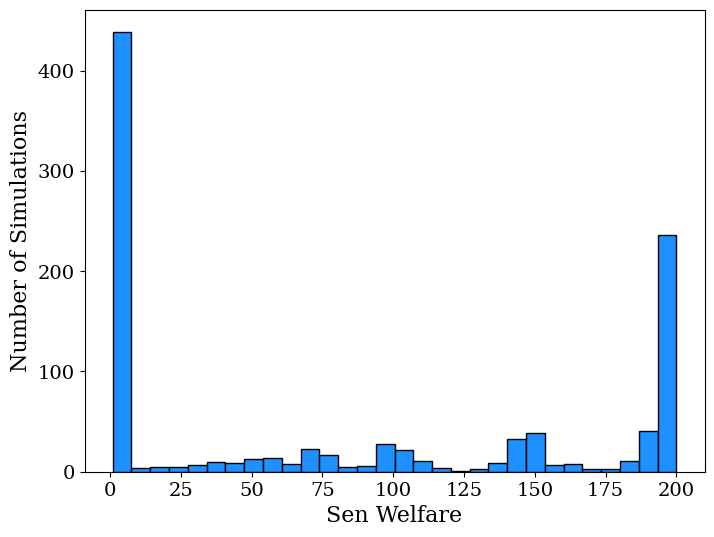

In [13]:
plt.hist(
    [t[1] for t in sen_results],
    bins=30,
    color="dodgerblue",
    edgecolor="k"
)
plt.xlabel("Sen Welfare")
plt.ylabel("Number of Simulations")
plt.show()

In [38]:
X = []
Y = []
for t in sen_results:
    X.append((t[0]["alpha"], t[0]["P_H_decrease"], t[0]["P_H_increase"], t[0]["gamma"], t[0]["w_delta_scale"], t[0]["gamma"], t[0]["eta"]))
    Y.append(t[1])
X = np.array(X)
Y = np.array(Y)


sen_pawn = pawn.analyze(problem, X, Y, S=10, print_to_console=False)
print(sen_pawn["mean"])

[0.41692621 0.09956619 0.10389998 0.09580917 0.17478137 0.09580917
 0.08393561]


In [39]:
morris.analyze(problem, X, Y, print_to_console=False)

{'names': array(['alpha', 'prob_health_decrease', 'prob_health_increase', 'gamma',
        'w_delta_scale', 'omega', 'eta'], dtype='<U20'),
 'mu': masked_array(data=[-465.2141856169661, -1.738274811695852,
                    88.4448391868262, 75.15923703385769, 198.0616769586111,
                    75.15923703385769, 28.307893232973935],
              mask=[False, False, False, False, False, False, False],
        fill_value=1e+20),
 'mu_star': masked_array(data=[475.18556712214433, 263.1234325528924,
                    265.264343290717, 248.03656567263158,
                    288.01659308046857, 248.03656567263158,
                    256.46559511494644],
              mask=[False, False, False, False, False, False, False],
        fill_value=1e+20),
 'sigma': array([257.87870827, 327.27141319, 322.14160879, 311.26896806,
        294.71738755, 311.26896806, 315.2747927 ]),
 'mu_star_conf': masked_array(data=[45.83765947063723, 38.26176015216706,
                    32.4550875952231

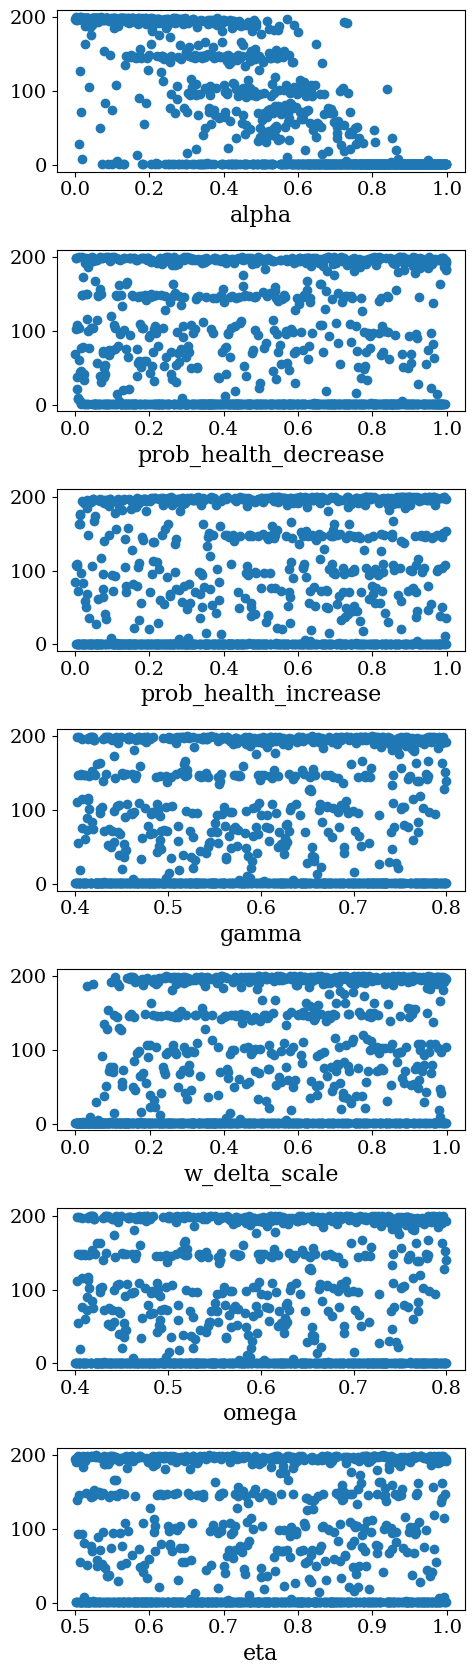

In [10]:
num_vars = problem["num_vars"]
fig, axs = plt.subplots(num_vars, 1, figsize=(5,17))
for idx in range(num_vars):
    axs[idx].scatter(
        X[:,idx],
        Y,
    )
    axs[idx].set_xlabel(problem["names"][idx])
fig.tight_layout()
plt.show()

### MFPT

In [29]:
def random_walk(n_steps, start_pos, step_size, interpolate, alpha, exp_factor=1):
    rand_nums = np.random.uniform(0, 1, size=(n_steps,))
    rand_angle = np.random.uniform(0, 2 * np.pi, size=(n_steps,))

    X = np.zeros((n_steps+1,))
    X[0] = start_pos[0]
    Y = np.zeros((n_steps+1,))
    Y[0] = start_pos[1]
    util = np.zeros((n_steps+1,))
    util[0] = utility(X[0], Y[0], alpha)
    current_potential = interpolate(X[0], Y[0])

    for step in range(n_steps):
        dx = np.cos(rand_angle[step]) * step_size
        dy = np.sin(rand_angle[step]) * step_size

        new_x = max(1, min(X[step] + dx, 200))
        new_y = max(1, min(Y[step] + dy, 200))        
        new_potential = interpolate(new_x, new_y, grid=False)

        # check whether to accept or reject moves
        accept = False
        if (new_potential < current_potential) or rand_nums[step] < exp_factor * np.exp(current_potential - new_potential):
            accept = True        
            current_potential = new_potential
            X[step+1] = new_x
            Y[step+1] = new_y
        else:
            X[step+1] = X[step]
            Y[step+1] = Y[step]
        
        util[step+1] = utility(X[step+1], Y[step+1], alpha)

    return util, X, Y

In [12]:
result_dir = "results_" + result_suffix

interpolation_functions = []
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    interp_func = get_interpolation_function(
        res["wealth"][:,-1],
        res["health"][:,-1]
    )
    interpolation_functions.append(
        (res["params"], interp_func)
    )

with open(f"interpolation_functions_{result_suffix}.pickle", "wb") as f:
    pickle.dump(interpolation_functions, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [31]:
with open(f"interpolation_functions_{result_suffix}.pickle", "rb") as f:
    interpolation_functions = pickle.load(f)

In [14]:
MINIMA = []
for param_set, func in tqdm(interpolation_functions):
    MINIMA.append(
        (param_set, get_minima(func, count_threshold=2, num_points=15, N=param_set["N"], step_size=10))
    )

with open(f"minima_{result_suffix}.pickle", "wb") as f:
    pickle.dump(MINIMA, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [40]:
with open(f"minima_{result_suffix}.pickle", "rb") as f:
    MINIMA = pickle.load(f)

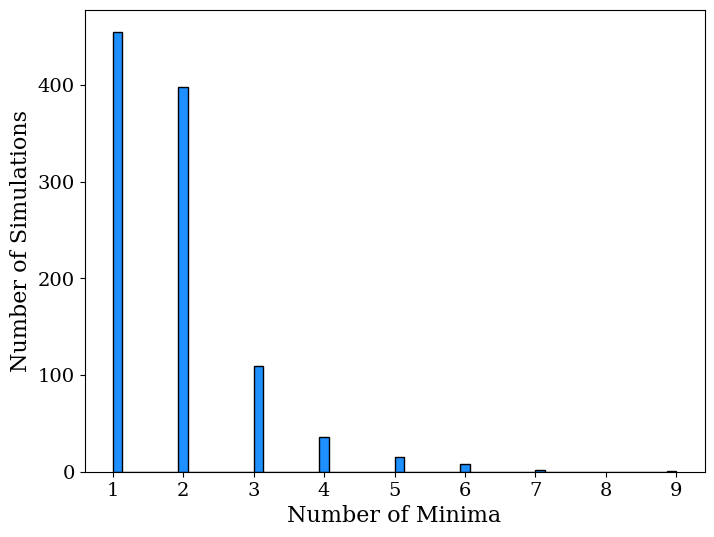

In [41]:
histo = plt.hist(
    [len(m[1]) for m in MINIMA],
    bins=60,
    color="dodgerblue",
    edgecolor="k"
)
plt.xlabel("Number of Minima")
plt.ylabel("Number of Simulations")
plt.show()

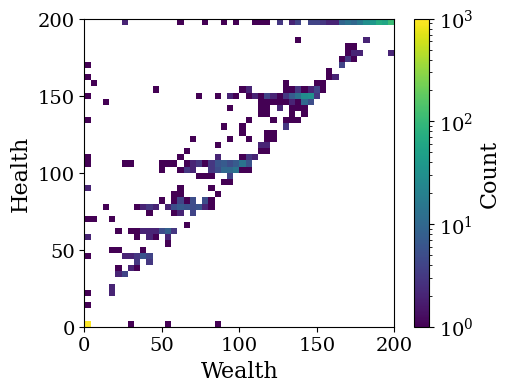

In [42]:
minima_locations = []
for m in MINIMA:
    for point in m[1]:
        minima_locations.append(point[0])

plt.figure(figsize=(5,4))
hist = plt.hist2d(
    [x[0] for x in minima_locations],
    [x[1] for x in minima_locations],
    bins=50,
    norm="log"
)
cbar = plt.colorbar(hist[3], label="Count")
cbar.set_ticks([1, 10, 100, 1000])

plt.xlabel("Wealth")
plt.ylabel("Health")
plt.savefig("minima_locations.pdf", bbox_inches="tight")
plt.show()

In [32]:
all_utils = []
for simulation_idx, item in tqdm(enumerate(MINIMA)):
    params, minima_list = item
    util_diffs = []
    for i in range(len(minima_list)):
        if minima_list[i][1] <= 2:
            continue
        w_i, h_i = minima_list[i][0]
        util, x, y = random_walk(100, (w_i,h_i), 1, interpolation_functions[simulation_idx][1], params["alpha"], exp_factor=0.5)
        util_diffs.append(util.max() - util[0])
    all_utils.append(
        (
            params,
            np.mean(util_diffs)
        )
    )

0it [00:00, ?it/s]

In [34]:
X = []
Y = []
for t in all_utils:
    X.append((t[0]["alpha"], t[0]["P_H_decrease"], t[0]["P_H_increase"], t[0]["gamma"], t[0]["w_delta_scale"], t[0]["gamma"], t[0]["eta"]))
    Y.append(t[1])
X = np.array(X)
Y = np.array(Y)

util_improvement_pawn = pawn.analyze(problem, X, Y, S=10, print_to_console=False)
util_improvement_pawn["mean"]

array([0.28352149, 0.09282058, 0.10778712, 0.07085837, 0.12545781,
       0.07085837, 0.08110081])

In [36]:
morris.analyze(problem, X, Y, print_to_console=False)

{'names': array(['alpha', 'prob_health_decrease', 'prob_health_increase', 'gamma',
        'w_delta_scale', 'omega', 'eta'], dtype='<U20'),
 'mu': masked_array(data=[4.943471523366197, -0.9480598689312016,
                    -0.9732193311568544, -0.1685008632951801,
                    -0.5234076309379695, -0.1685008632951801,
                    -0.15703347426049857],
              mask=[False, False, False, False, False, False, False],
        fill_value=1e+20),
 'mu_star': masked_array(data=[5.747726943454261, 4.346556024799578,
                    4.5998568785721705, 4.731831587391241,
                    4.361124505680067, 4.731831587391241,
                    4.8187341551399365],
              mask=[False, False, False, False, False, False, False],
        fill_value=1e+20),
 'sigma': array([4.97354777, 5.26119218, 5.6329738 , 5.84267899, 5.47737721,
        5.84267899, 5.70549612]),
 'mu_star_conf': masked_array(data=[0.6896472154928341, 0.5787097333831008,
                   

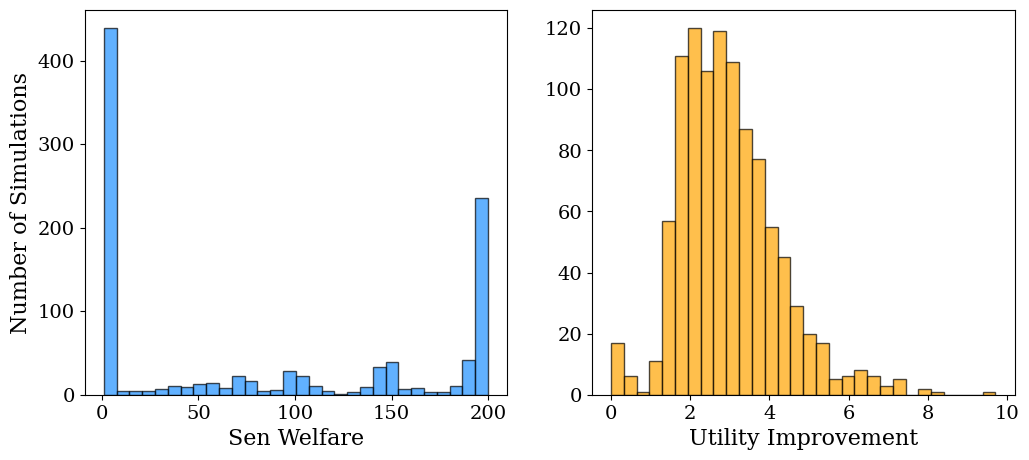

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].hist(
    [t[1] for t in sen_results],
    bins=30,
    color="dodgerblue",
    edgecolor="k",
    alpha=0.7
)
axs[0].set_xlabel("Sen Welfare")
axs[0].set_ylabel("Number of Simulations")

axs[1].hist(
    [x[1] for x in all_utils],
    color="orange",
    edgecolor="k",
    bins=30,
    alpha=0.7
)
axs[1].set_xlabel("Utility Improvement")

plt.savefig("gsa_distributions.pdf", bbox_inches="tight")

plt.show()

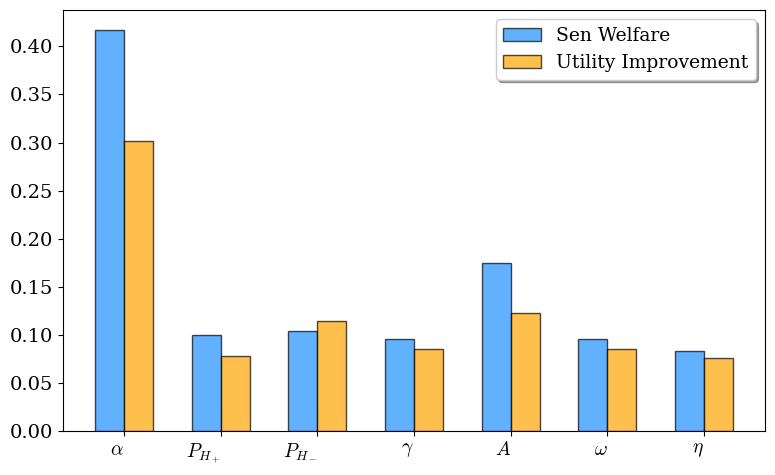

In [19]:
# Categories on x-axis
categories = [r'$\alpha$', r'$P_{H_+}$', r'$P_{H_-}$', r'$\gamma$', r'$A$', r'$\omega$', r'$\eta$']

# Data for the bars
sen_values = sen_pawn["mean"]
util_values = util_improvement_pawn["mean"]

# X locations for the groups
x = np.arange(len(categories))

# Width of bars
width = 0.3  

# Create bar chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, sen_values, width, label='Sen Welfare', color='dodgerblue', alpha=0.7, edgecolor="k")
ax.bar(x + width/2, util_values, width, label='Utility Improvement', color='orange', alpha=0.7, edgecolor="k")

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(categories, ha="right")
ax.legend(shadow=True)

# Show plot
plt.tight_layout()
plt.savefig("pawn_sensitivity_indices.pdf", bbox_inches="tight")
plt.show()

### Minima Stability

In [25]:
with open(f"minima_{result_suffix}.pickle", "rb") as f:
    MINIMA = pickle.load(f)

In [26]:
def compute_flux(wealth, health, a, b, delta=4):
    inn, out = 0, 0
    visits = np.zeros(wealth.shape[0])
    for t in range(wealth.shape[1]):        
        # IN
        if t == 0:
            reached = np.where( (np.abs(wealth[:,t] - a) <= delta) & (np.abs(health[:,t] - b) <= delta) )[0]
        else:
            reached = np.where( ((np.abs(wealth[:,t] - a) <= delta) & (np.abs(health[:,t] - b) <= delta)) & 
                                 ((np.abs(wealth[:,t-1] - a) > delta) | (np.abs(health[:,t-1] - b) > delta)) )[0]
        inn += len(reached)
        visits[reached] +=1
        # OUT
        if t > 0:
            left = np.where( ((np.abs(wealth[:,t] - a) > delta) | (np.abs(health[:,t] - b) > delta)) & 
                             ((np.abs(wealth[:,t-1] - a) <= delta) & (np.abs(health[:,t-1] - b) <= delta)) )[0]
            out += len(left)

    return (inn,out), visits

In [72]:
flux_result = []
for idx,f in tqdm(enumerate(os.listdir(result_dir))):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    r = {}
    for m in MINIMA[idx][1]:
        a,b = m[0]
        in_out_counts, visits = compute_flux(wealth, health, a, b)
        r[(a,b)] = (in_out_counts, visits)
    flux_result.append((idx, r))

with open(f"flux_{result_suffix}.pickle", "wb") as f:
    pickle.dump(flux_result, f)

0it [00:00, ?it/s]

In [10]:
with open(f"flux_{result_suffix}.pickle", "rb") as f:
    flux_result = pickle.load(f)
with open(f"interpolation_functions_{result_suffix}.pickle", "rb") as f:
    interpolation_functions = pickle.load(f)

In [263]:
cycle = set()
for item in flux_result:
    idx = item[0]
    mins = item[1]
    if len(mins) < 2:
        continue
    count = 0
    for k in mins:
        inn, out = mins[k][0]
        if inn > 500000 and out > 500000 and round(inn/out, 1) == 1.0:
            count += 1
    if count > 1:
        cycle.add(idx)
print(len(cycle))

cycle_arr = []
no_cycle_arr = []
for idx,f in tqdm(enumerate(os.listdir(result_dir))):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    p = res["params"]
    if idx in cycle:
        cycle_arr.append(
            (p["alpha"],p["P_H_decrease"], p["P_H_increase"], p["gamma"], p["w_delta_scale"], p["gamma"], p["eta"])
        )
    else:
        no_cycle_arr.append(
            (p["alpha"],p["P_H_decrease"], p["P_H_increase"], p["gamma"], p["w_delta_scale"], p["gamma"], p["eta"])
        )
cycle_arr = np.stack(cycle_arr)
no_cycle_arr = np.stack(no_cycle_arr)

53


0it [00:00, ?it/s]

In [278]:
mins[k][1][np.where(mins[k][1] > 0)[0]]

array([1., 1., 1., ..., 1., 1., 1.])

In [287]:
high_revisit = set()
for item in flux_result:
    idx = item[0]
    mins = item[1]
    for k in mins:
        revisits = mins[k][1][np.where(mins[k][1] > 0)[0]]
        mean_revisit = np.mean(revisits)
        if mean_revisit > 100:
            high_revisit.add(idx)
print(len(high_revisit))

high_rev = []
low_rev = []
for idx,f in tqdm(enumerate(os.listdir(result_dir))):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    p = res["params"]
    if idx in high_revisit:
        high_rev.append(
            (p["alpha"],p["P_H_decrease"], p["P_H_increase"], p["gamma"], p["w_delta_scale"], p["gamma"], p["eta"])
        )
    else:
        low_rev.append(
            (p["alpha"],p["P_H_decrease"], p["P_H_increase"], p["gamma"], p["w_delta_scale"], p["gamma"], p["eta"])
        )
high_rev = np.stack(high_rev)
low_rev = np.stack(low_rev)

265


0it [00:00, ?it/s]

In [253]:
single_min = set()
for item in flux_result:
    idx = item[0]
    mins = item[1]
    if len(mins) == 1:
        single_min.add(idx)

single_min_arr = []
multi_min_arr = []
for idx,f in tqdm(enumerate(os.listdir(result_dir))):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    p = res["params"]
    if idx in single_min:
        single_min_arr.append(
            (p["alpha"],p["P_H_decrease"], p["P_H_increase"], p["gamma"], p["w_delta_scale"], p["gamma"], p["eta"])
        )
    else:
        multi_min_arr.append(
            (p["alpha"],p["P_H_decrease"], p["P_H_increase"], p["gamma"], p["w_delta_scale"], p["gamma"], p["eta"])
        )

single_min_arr = np.stack(single_min_arr)
multi_min_arr = np.stack(multi_min_arr)

0it [00:00, ?it/s]

In [250]:
high_sen = set()
for idx,item in enumerate(sen_results):
    if item[1] > 175:
        high_sen.add(idx)

high_sen_arr = []
low_sen_arr = []
for idx,f in tqdm(enumerate(os.listdir(result_dir))):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    p = res["params"]
    if idx in high_sen:
        high_sen_arr.append(
            (p["alpha"],p["P_H_decrease"], p["P_H_increase"], p["gamma"], p["w_delta_scale"], p["gamma"], p["eta"])
        )
    else:
        low_sen_arr.append(
            (p["alpha"],p["P_H_decrease"], p["P_H_increase"], p["gamma"], p["w_delta_scale"], p["gamma"], p["eta"])
        )
high_sen_arr = np.stack(high_sen_arr)
low_sen_arr = np.stack(low_sen_arr)

0it [00:00, ?it/s]

In [349]:
stability_counts = {}
for item in flux_result:
    idx = item[0]
    mins = item[1]
    sc = {"stable":0, "unstable":0}
    for k in mins:
        inn, out = mins[k][0]
        if inn / (out+1e-5) > 3:
            sc["stable"] += 1
        else:
            sc["unstable"] += 1
    stability_counts[idx] = sc

stable = []
unstable = []
for idx,f in tqdm(enumerate(os.listdir(result_dir))):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    p = res["params"]
    if stability_counts[idx]["stable"] > 1:
        stable.append(
            (p["alpha"],p["P_H_decrease"], p["P_H_increase"], p["gamma"], p["w_delta_scale"], p["gamma"], p["eta"])
        )
    else:
        unstable.append(
            (p["alpha"],p["P_H_decrease"], p["P_H_increase"], p["gamma"], p["w_delta_scale"], p["gamma"], p["eta"])
        )
stable = np.stack(stable)
unstable = np.stack(unstable)

0it [00:00, ?it/s]

In [294]:
def radar_plot(X1, X2, labels):
    colors = ['dodgerblue', 'crimson']
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    for i,arr in enumerate([X1, X2]):
        means = np.mean(arr, axis=0)
        stds = np.std(arr, axis=0)
        
        # Number of variables
        num_vars = len(means)
        
        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Close the polygon
        
        # Repeat the first value to close the shape
        values = means.tolist()
        values += values[:1]
        
        std_upper = (means + stds).tolist()
        std_upper += std_upper[:1]
        
        std_lower = (means - stds).tolist()
        std_lower += std_lower[:1]
        
        # Plot
        ax.plot(angles, values, color=colors[i], linewidth=1, label=labels[i])
        ax.fill_between(angles, std_lower, std_upper, color=colors[i], alpha=0.1)

    # Set labels
    labels = [r"$\alpha$", r"$P_{H_-}$", r"$P_{H_+}$", r"$\gamma$", r"$A$", r"$\omega$", r"$\eta$"]
    ax.legend()
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    plt.show()

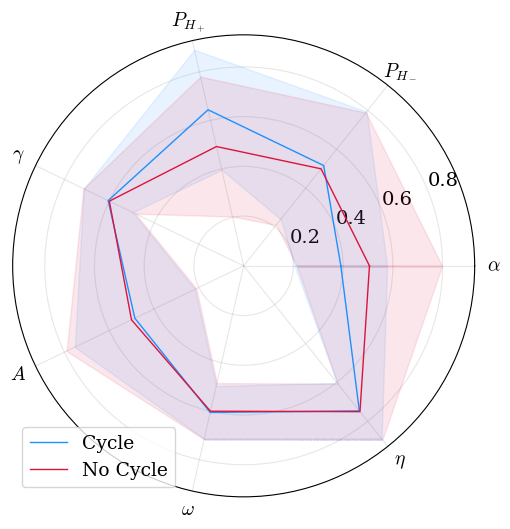

In [317]:
radar_plot(cycle_arr, no_cycle_arr, labels=["Cycle", "No Cycle"])

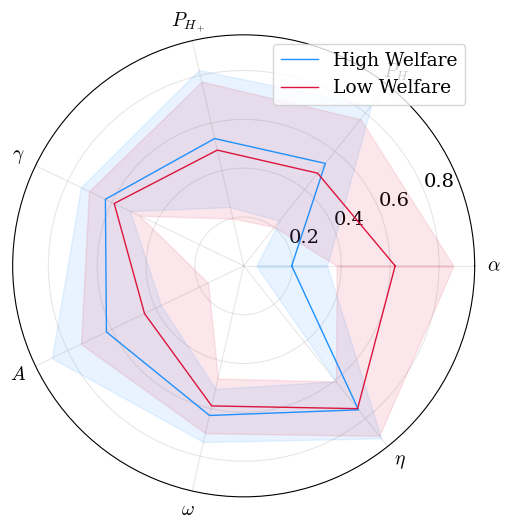

In [318]:
radar_plot(high_sen_arr, low_sen_arr, labels=["High Welfare", "Low Welfare"])

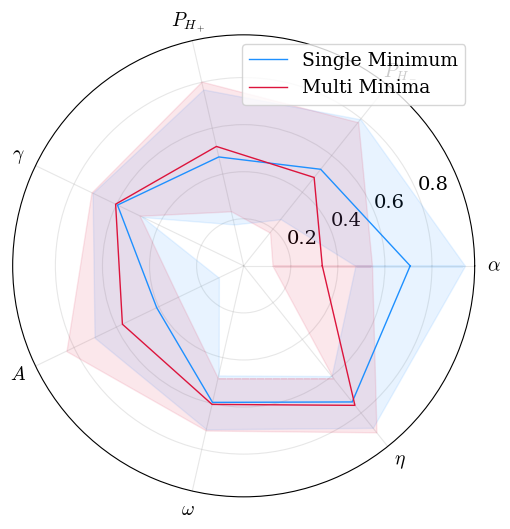

In [319]:
radar_plot(single_min_arr, multi_min_arr, labels=["Single Minimum", "Multi Minima"])

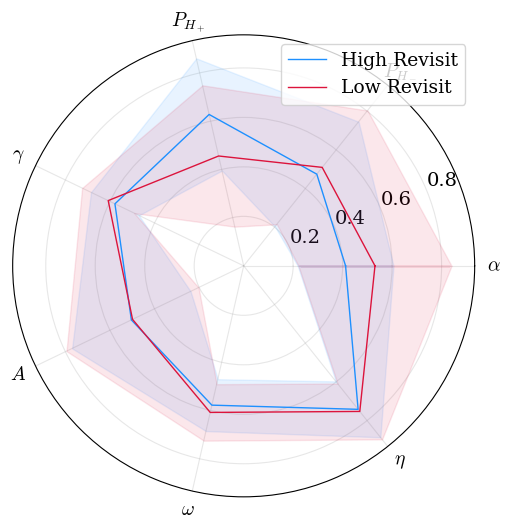

In [320]:
radar_plot(high_rev, low_rev, labels=["High Revisit", "Low Revisit"])

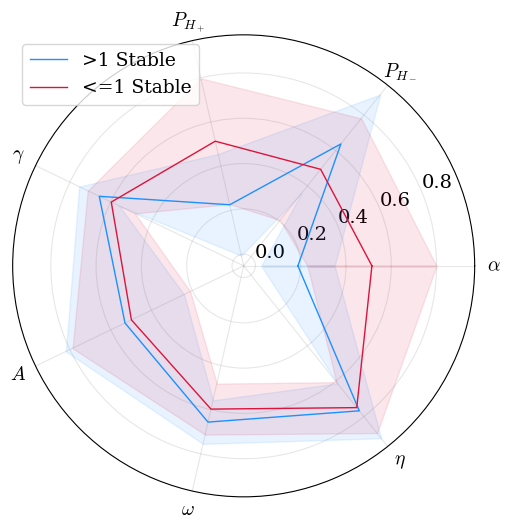

In [352]:
radar_plot(stable, unstable, labels=[">1 Stable", "<=1 Stable"])

In [332]:
# idx = 394

# f = os.listdir(result_dir)[idx]

# with open(os.path.join(result_dir, f), "rb") as f:
#     res = pickle.load(f)
# wealth = res["wealth"]
# health = res["health"]

# asdf = np.zeros((200,200))
# for w in range(200):
#     for h in range(200):
#         asdf[w][h] = interpolation_functions[idx][1](w,h)
# plt.matshow(asdf.T, origin="lower")
# plt.show()

### Minima Zoo

120


/var/folders/mz/n_rzzjx149d19ncnxglpf7n40000gn/T/ipykernel_38489/2413798572.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asdf[w][h] = func(w,h)


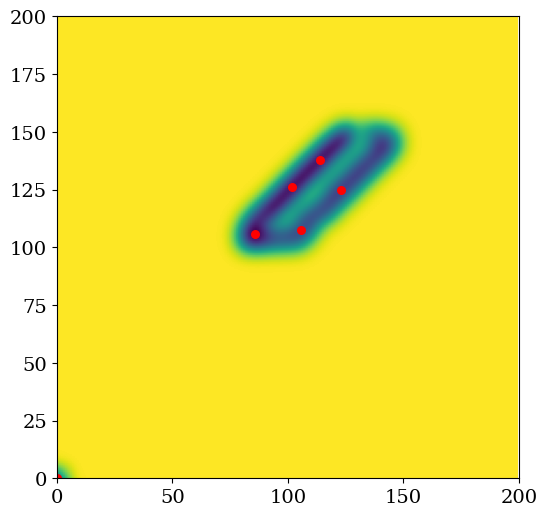

253


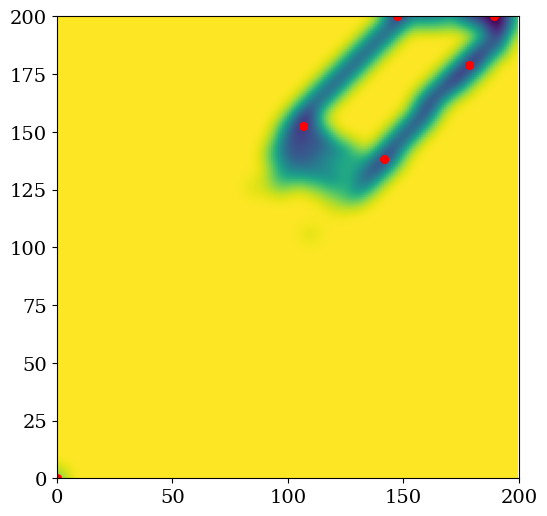

264


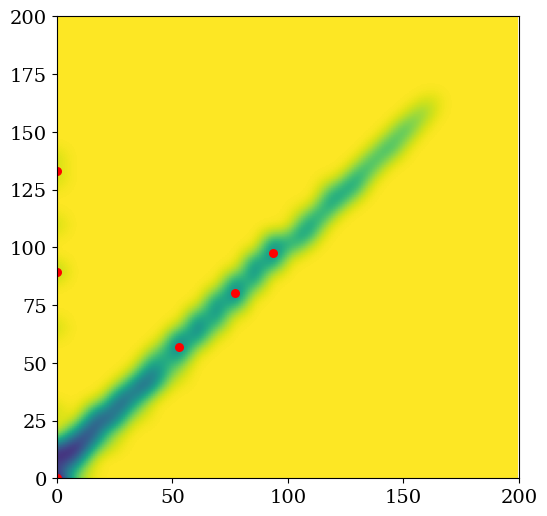

549


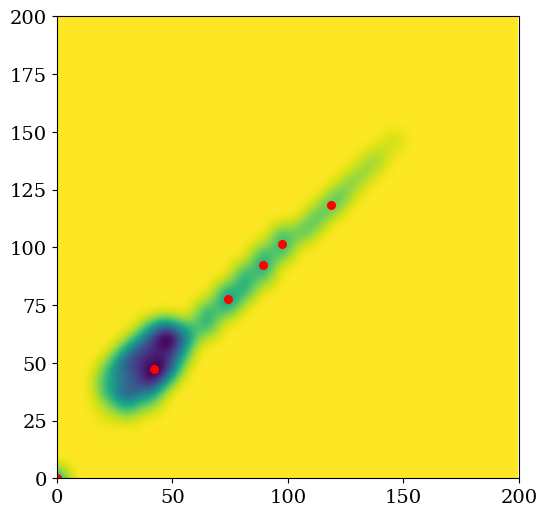

770


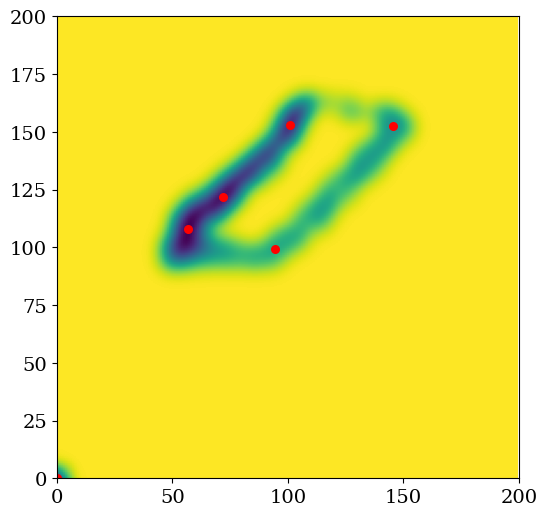

849


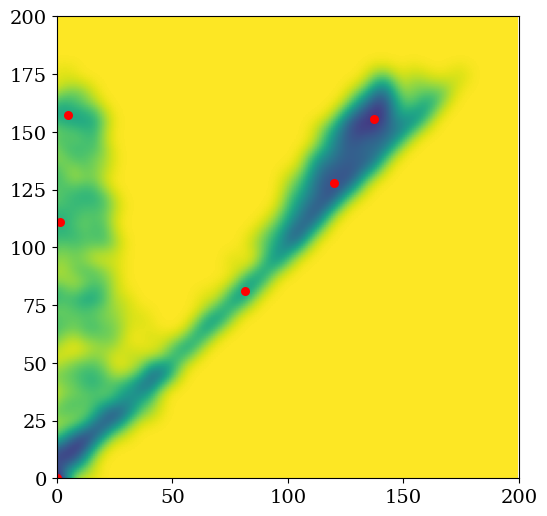

896


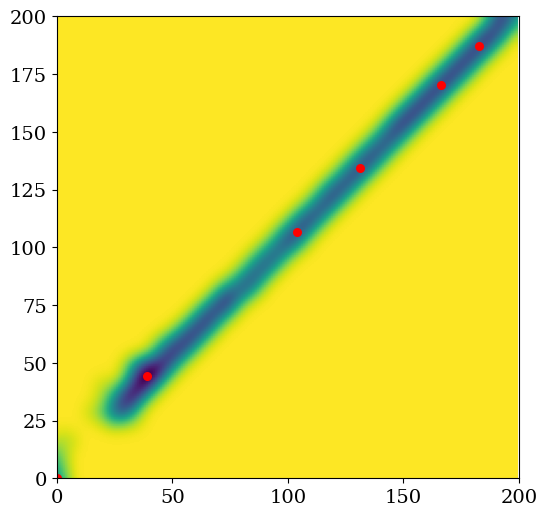

970


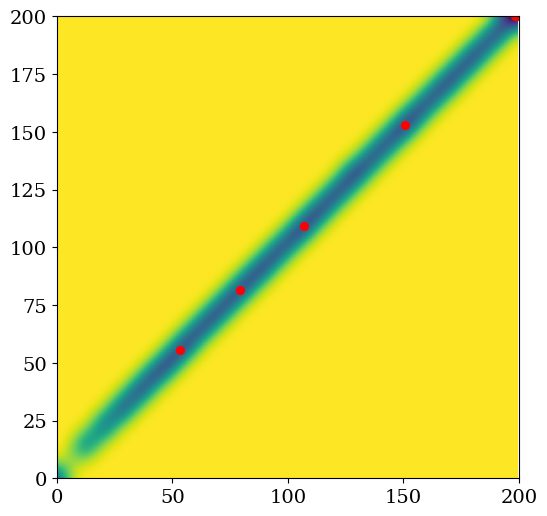

In [275]:
minima_locations = []
for i,m in enumerate(MINIMA):
    if len(m[1]) == 6:
        print(i)
        asdf = np.zeros((200,200))
        func = interpolation_functions[i][1]
        points = m[1]
        zero_zero = False
        # for p in points:
        #     if p[0][0] == 0 and p[0][1] == 0:
        #         zero_zero = True
        # if not zero_zero:
        #     print(points)
        for w in range(200):
            for h in range(200):
                asdf[w][h] = func(w,h)
        plt.imshow(asdf.T, origin="lower")
        plt.scatter(
            [p[0][0] for p in points],
            [p[0][1] for p in points], 
            color="red", s=30
        )
        plt.xlim(0,200)
        plt.ylim(0,200)
        plt.show()

/var/folders/mz/n_rzzjx149d19ncnxglpf7n40000gn/T/ipykernel_11720/1036540595.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asdf[w][h] = func(w,h)
/var/folders/mz/n_rzzjx149d19ncnxglpf7n40000gn/T/ipykernel_11720/1036540595.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asdf[w][h] = func(w,h)
/var/folders/mz/n_rzzjx149d19ncnxglpf7n40000gn/T/ipykernel_11720/1036540595.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asdf[w][h] = func(w,h)
/var/folders/

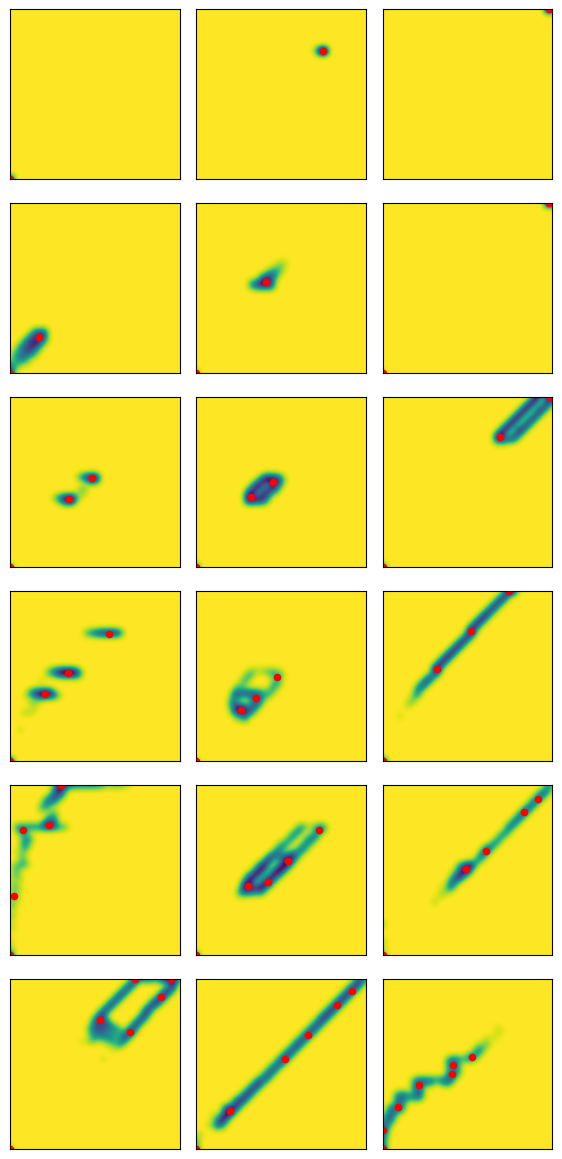

In [246]:
fig, axs = plt.subplots(6, 3, figsize=(7,15))

# 1 minimum
indices = [3, 106, 431]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[0][i].imshow(asdf.T, origin="lower")
    axs[0][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[0][i].set_xlim(0,200)
    axs[0][i].set_ylim(0,200)
    axs[0][i].set_xticks([])
    axs[0][i].set_yticks([])

# 2 minima
indices = [130, 2, 197]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[1][i].imshow(asdf.T, origin="lower")
    axs[1][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[1][i].set_xlim(0,200)
    axs[1][i].set_ylim(0,200)
    axs[1][i].set_xticks([])
    axs[1][i].set_yticks([])

# 3 minima
indices = [512, 387, 757]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[2][i].imshow(asdf.T, origin="lower")
    axs[2][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[2][i].set_xlim(0,200)
    axs[2][i].set_ylim(0,200)
    axs[2][i].set_xticks([])
    axs[2][i].set_yticks([])

# 4 minima
indices = [417, 314, 880]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[3][i].imshow(asdf.T, origin="lower")
    axs[3][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[3][i].set_xlim(0,200)
    axs[3][i].set_ylim(0,200)
    axs[3][i].set_xticks([])
    axs[3][i].set_yticks([])

# 5 minima
indices = [15, 533, 567]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[4][i].imshow(asdf.T, origin="lower")
    axs[4][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[4][i].set_xlim(0,200)
    axs[4][i].set_ylim(0,200)
    axs[4][i].set_xticks([])
    axs[4][i].set_yticks([])

# 6, 7 minima
indices = [253, 896, 54]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[5][i].imshow(asdf.T, origin="lower")
    axs[5][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[5][i].set_xlim(0,200)
    axs[5][i].set_ylim(0,200)
    axs[5][i].set_xticks([])
    axs[5][i].set_yticks([])

fig.subplots_adjust(hspace=0.05, wspace=0.1)
plt.savefig("minima_zoo.pdf", bbox_inches="tight")
plt.show()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

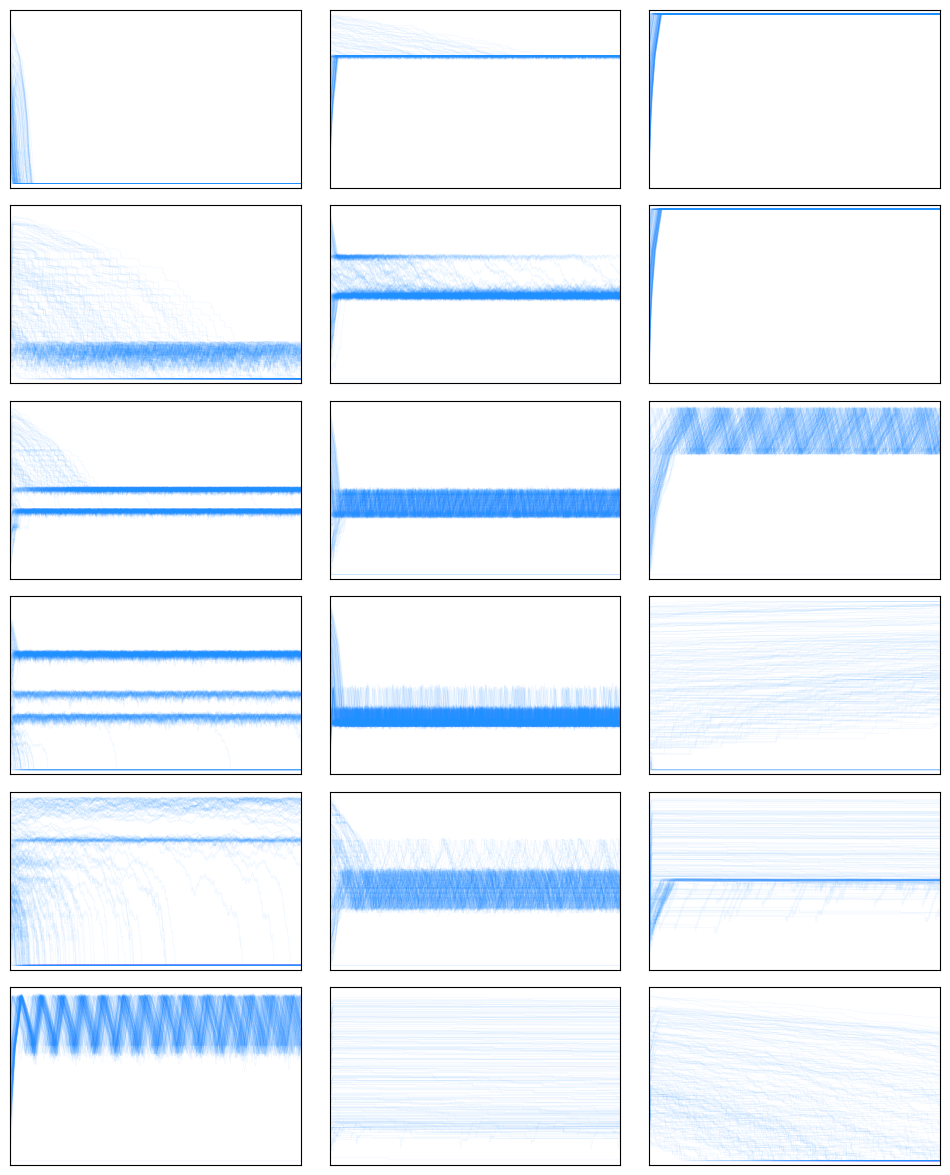

In [29]:
filenames = os.listdir(result_dir)

fig, axs = plt.subplots(6, 3, figsize=(12,15))

num_agents = 200
max_T = 3000
alpha = 0.06

# 1
indices = [3, 106, 431]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[0][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

# 2
indices = [130, 2, 197]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[1][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

# 3
indices = [512, 387, 757]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[2][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")
    
# 4
indices = [417, 314, 880]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[3][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

# 5
indices = [15, 533, 567]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[4][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

# 6, 7
indices = [253, 896, 54]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[5][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

for i in range(6):
    for j in range(3):
        axs[i][j].set_xlim(0,2500)
        axs[i][j].set_ylim(-4,204)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])

fig.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig("trajectories_zoo.png", bbox_inches="tight")
plt.show()

### Investigate final state space outcome as function of initial state

In [45]:
init_w = []
init_h = []

result_dir = "results_" + result_suffix
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    condition = (wealth[:,-1] <=5) & (health[:,-1] <=5)
    init_w.append(wealth[condition,0])
    init_h.append(health[condition,0])

init_w = np.concatenate(init_w)
init_h = np.concatenate(init_h)

  0%|          | 0/1024 [00:00<?, ?it/s]

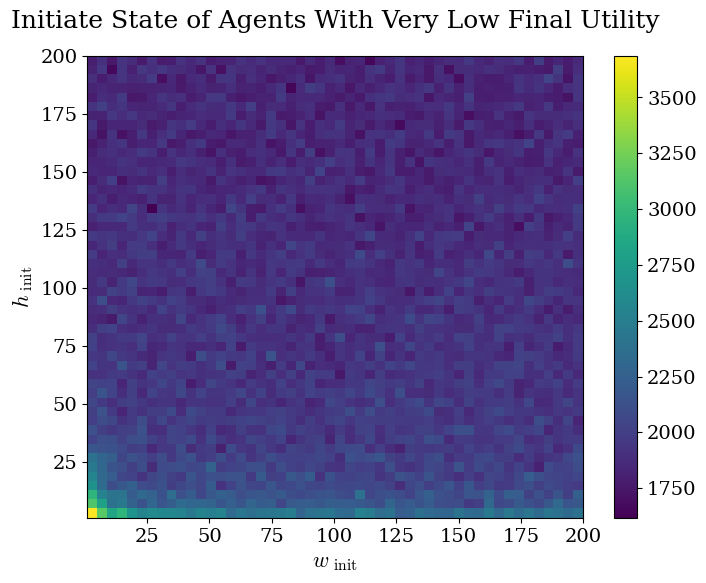

In [46]:
fig, ax = plt.subplots()
h = ax.hist2d(init_w, init_h, bins=50)
fig.colorbar(h[3], ax=ax)
plt.xlabel(r"$w_{\text{ init}}$")
plt.ylabel(r"$h_{\text{ init}}$")
plt.title("Initiate State of Agents With Very Low Final Utility", pad=20)
plt.show()